<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Value-Function-Approximation-for-Mountain-Car-Problem" data-toc-modified-id="Value-Function-Approximation-for-Mountain-Car-Problem-1">Value Function Approximation for Mountain Car Problem</a></span></li><li><span><a href="#Sources-of-Inspiration" data-toc-modified-id="Sources-of-Inspiration-2">Sources of Inspiration</a></span></li></ul></div>

Value Function Approximation for Mountain Car Problem
-----

<center><img src="images/mountain_car.gif" width="75%"/></center>

[Mountain car problem](https://en.wikipedia.org/wiki/Mountain_car_problem)

Goal - Get car to the flag pole.

Why it is interesting?

Car has to learn to accelerate away from the pole (i.e., non-greedy policy) to get momentum to get the steep hill.

[Video demo](https://www.youtube.com/watch?v=9dvFbXXQuhY)

[Policy visualization](https://medium.com/@ts1829/solving-mountain-car-with-q-learning-b77bf71b1de2)

Function approximation can solve the mountain car problem by by generating a set of basis functions as the car drives.

The agent can approximate the value function at each state, thus cleanly estimate the true smooth function of the mountain car domain.

In [1]:
reset -fs

In [2]:
import itertools
import sys

import gym
import matplotlib
import numpy as np
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

import plotting

%matplotlib inline
matplotlib.style.use('ggplot')

In [3]:
env = gym.envs.make("MountainCar-v0")

In [4]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for _ in range(10_000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

[Review of RBF kernal](http://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/svms/RBFKernel.pdf)

In [5]:
class Estimator():
    "Value Function approximator."
    
    def __init__(self):
        """We create a separate model for each action in the environment's action space. 
        Alternatively we could somehow encode the action into the features, 
        but this way it's easier to code up."""
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # Call partial_fit once to initialize the model or we get a NotFittedError when trying to make a prediction
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        "Calculate the featurized representation for a state."
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, state, action=None):
        "Calculate value function predictions."
        features = self.featurize_state(state)
        if not action:
            # If no action is given this returns a vector or predictions for all actions in the environment where pred[i] is the prediction for action i.
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            # If an action a is given returns a single number as the prediction.
            return self.models[action].predict([features])[0]
    
    def update(self, state, action, target):
        "Updates the estimator parameters for a given state and action towards the target."
        features = self.featurize_state(state)
        self.models[action].partial_fit([features], [target])

In [6]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [7]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
                        
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            if next_action is None:
                action_probs = policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            
            # Use this code for Q-Learning
            # Q-Value TD Target
            td_target = reward + discount_factor * np.max(q_values_next)
            
            # Use this code for SARSA TD Target for on policy-training:
            # next_action_probs = policy(next_state)
            # next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            # td_target = reward + discount_factor * q_values_next[next_action]
            
            # Update the function approximator using our target
            estimator.update(state, action, td_target)
            
            print(f"\rStep {t:0} @ Episode {i_episode+1}/{num_episodes} ({last_reward})", end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [8]:
estimator = Estimator()

In [9]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads to the exploration of all states.
stats = q_learning(env, estimator, 100, epsilon=0.0)

Step 199 @ Episode 100/100 (-164.0)

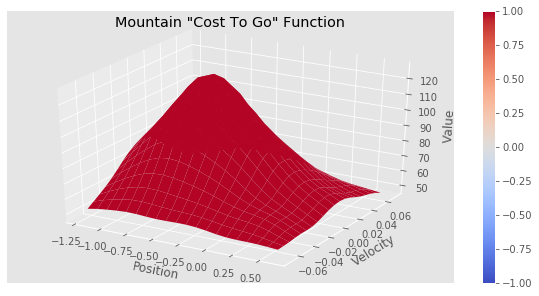

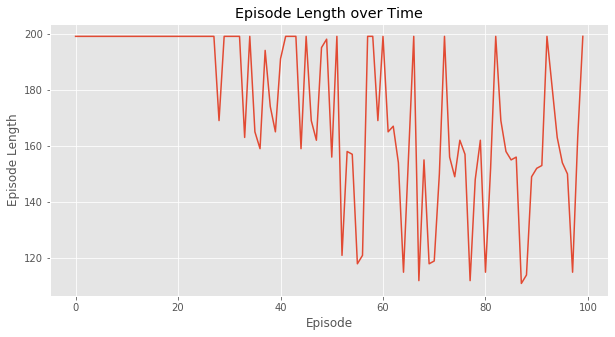

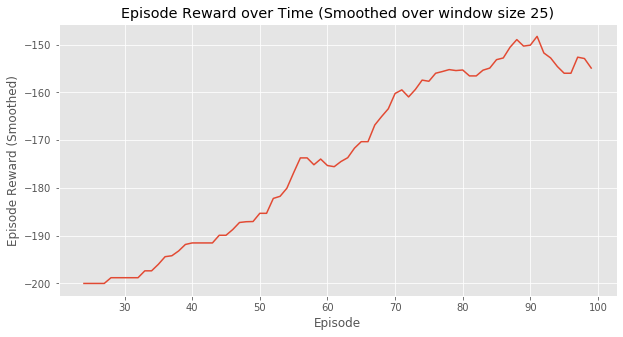

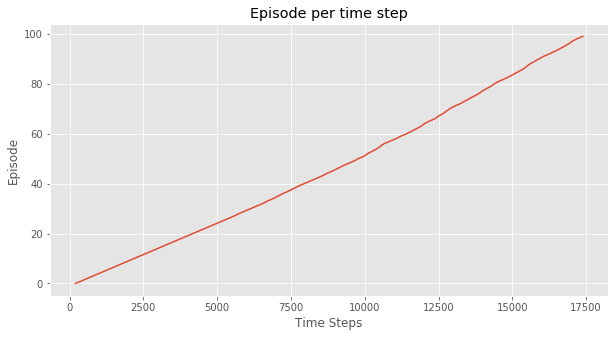

In [10]:
plotting.plot_cost_to_go_mountain_car(env, estimator);
plotting.plot_episode_stats(stats, smoothing_window=25);

<center><h2>Sources of Inspiration</h2></center>

- https://www.youtube.com/watch?v=9dvFbXXQuhY
- https://medium.com/@ts1829/solving-mountain-car-with-q-learning-b77bf71b1de2
- https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation%20Solution.ipynb
- https://github.com/dennybritz/reinforcement-learning/issues/84